# 1. Импорт библиотек, подключение к MondoDB, настройка 

* `response.content` - сырое содержание байты
* `response.text` - перевод в текст
* `response.json` - если получили такой ответ, то можем его перевести в Python объект, схоже с `json_load`

## Импорт библиотек

In [4]:
from pymongo import MongoClient
from pymongo import UpdateOne
from extrans import pos_neg_comment_dic as comment_type #
from extrans import categories_words_collection_dic as categories

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html
from pandas.io.json import json_normalize

In [5]:
%load_ext autoreload
%autoreload 1
%aimport extrans
%aimport

Modules to reload:
extrans

Modules to skip:



# Настройка - Параметры - Константы

In [17]:
#==================Параметры определяющие: делать ли загрузку новых постов, производить ли их обработку
GET_NEW_DATA = True # True\False - определяем получать ли новые данные
TRANSFORM_DATA = True # Производить ли обработку документов

#===================Переменные среды=============================================================
VK_TOKEN = '5e750d325e750d325e750d32dd5e1a9bc455e755e750d32004bf78601dd9d435b30b1b2'

# False # если получам новые данные, то нужен ключ от приложения в VK : str
HOW_MANY_POSTS_TO_GET = 10 # Сколько последних постов получить ❗ Уменьшено до 100 с 1000, для тестирования
OWNER_ID = -95095088 # ID паблика в VK, перед числом ставить минус #https://vk.com/club95095088

# MongoDB в облаке Google cloud

In [ ]:
# Параметры для подключения к MongoBD
# VPS сделан в Google cloud (бесплатное обслуживание - https://cloud.google.com/free)
# Установлена Ubuntu + Docker
# `docker run -d --name i109r --network="host" -p 27017:27017 -e MONGO_INITDB_ROOT_USERNAME=i109r -e MONGO_INITDB_ROOT_PASSWORD=i109r-vk mongo --auth`

# docker exec -it i109r mongo -u i109r -p i109r-vk
# В фаерволе сделаны правила для пропуска входящего\исходящего трафика порт 27017
  

# MC = {
#     'host': '34.83.234.192',
#     'port': 27017,
#     'user': 'i109r',
#     'password': 'i109r-vk',
#     'authSource': 'admin'
# }

## Подключение к MongoDB

In [28]:
# ❗ Облако
#client = MongoClient(f"mongodb://{MC['user']}:{MC['password']}@{MC['host']}:{MC['port']}/{MC['authSource']}")

client = MongoClient('mongodb://127.0.0.1:27017')


# Выбираем базу с которой будем работать
db = client['vk']
# Выбираем\Создаём коллекции для работы - как соединенеия с БД
# Созданы объекты, к атрибутам и методам которых можно обращаться
# Используются для поиска, модификации, удаления документов в коллекцих
coll_posts = db.posts
coll_comments = db.comments
coll_profiles = db.profiles

# 2. Получение данных и запись их в MongoDB
* Получаем посты, комментарии и профайлы и записываем в БД - `VK`:
  * Коллекции `coll_posts`, `coll_comments`, `coll_profiles`

## 2.1. Запись постов в коллекцию

In [29]:
%%time
# Запись постов в коллекцию (дописывает недостающие посты)
# Для получения более поздних (чем последние 1500), нужно параметры выставлять вручную
if GET_NEW_DATA:
    for offset in range(0, HOW_MANY_POSTS_TO_GET, 100):    
        raw_posts = extrans.get_posts(count=100, offset=offset, OWNER_ID=OWNER_ID, VK_TOKEN=VK_TOKEN)
        parsed_posts = extrans.parse_json_vk_posts(raw_posts)
        written_posts = extrans.write_posts_to_collection(parsed_posts, coll_posts)
        
        if written_posts is False:
            break

Новых документов для добавления: 100
Записано постов: 100
Сейчас «Постов» в коллекции: 100
Wall time: 717 ms


## 2.2. Запись комментариев в коллекцию

In [6]:
# %pdb

In [30]:
%%time

if GET_NEW_DATA:
    mongo_cursor_posts = coll_posts.find({'comments':{'$gt':0}})
    posts_ids = [i['id'] for i in mongo_cursor_posts]
    
    comments_counter = 0
    all_comments = []
    for post_id in posts_ids:
        raw_comments = extrans.get_comments(post_id=post_id, OWNER_ID=OWNER_ID, VK_TOKEN=VK_TOKEN)
        parsed_comments = extrans.parse_json_vk_comments(raw_comments)
        all_comments.extend(parsed_comments)
        comments_counter += 1
        
        if comments_counter % 100 == 0:
            print(comments_counter)
        
    written_comments = extrans.write_comments_to_collection(comments=all_comments, collection=coll_comments)

Новых документов для добавления: 167
Записано комментариев: 167
Сейчас «Комментариев» в коллекции: 167
Wall time: 12.7 s


## 2.3. Запись профайлов в коллекцию

In [31]:
%%time
# TODO Нет проверки на дубликаты при записи в БД, нет проверки на "открытие\появление" новых доступных полей профайла

if GET_NEW_DATA:
    mongo_cursor_profiles = coll_comments.find({}, {'from_id': True, '_id': False})
    profiles_ids = set([i['from_id'] for i in mongo_cursor_profiles])
    profiles_ids = list(profiles_ids)

    profiles_for_collection = []

    while len(profiles_ids) != 0:
        ids_100 = profiles_ids[0:100]
        del profiles_ids[0:100]
        part = extrans.get_profiles(ids=ids_100, VK_TOKEN=VK_TOKEN)
        profiles_for_collection.extend(part)
    
    # breakpoint()
    written_profiles = extrans.write_profiles_to_collection(profiles=profiles_for_collection, collection=coll_profiles)

Профайлов получено для обработки: 145
Количество дубликатов профайлов: 0
Записано профайлов: 145
Сейчас «Профайлов» в коллекции: 145
Wall time: 411 ms


# 3. Преобразование данных (документов) в коллекциях - подготовка для анализа  
* Обработка по глупости вначале была сделана от отдельному документу, локально всё работает достаточно быстро,
* При запуске БД в облаке, всё работает очень медленно. От 5 до 40 минут на ячейку - трансформирующую данные (в зависимости от того, сколько документов обработано ранее и сколько всего документов в коллекции).
* Возможно также на производительность влияет hdd, а не ssd в облаке.
* `.update_one` - изменён на `.bulk_write` - «Send a batch of write operations to the server. Requests are passed as a list of write operation instances ( InsertOne, UpdateOne, UpdateMany, ReplaceOne, DeleteOne, or DeleteMany).»
* Вероятно правильнее было бы делать разные коллекции и передавать данные как по **pipline**:
  * Получили ответы от ВК - всё записли как есть в коллекцию_1
  * Взяли всю коллекцию_1 - отобрали нужные поля и записали в коллекцию_2
  * Взяли то что есть в коллекции_2 - сделали модификации добавили поле даты и записали в коллекцию_3
  * ... и т.д.

## 3.1. Преобразование UNIX time в объекты datetime - коллекции `coll_posts`, `coll_comments`

### Документы с постами из сообщества

In [32]:
%%time
if TRANSFORM_DATA:
    extrans.add_datetime_to_documents(collection=coll_posts)

Внесены изменения в 100 документ из коллекции posts в базе данных vk
Wall time: 15.1 ms


### Документы с комментариями к постам в сообществе

In [33]:
%%time
if TRANSFORM_DATA:
    extrans.add_datetime_to_documents(collection=coll_comments)

Внесены изменения в 167 документ из коллекции comments в базе данных vk
Wall time: 18 ms


## 3.2. Разбиваем посты на отдельные слова и tags
* MongoDB - по разному отдаёт данные иногда логи пишутся по частям

### Коллекция постов

In [34]:
%%time
if TRANSFORM_DATA:
    extrans.add_tags_words_to_documents(collection=coll_posts)

---------------TAG---------------
Внесены изменения в 100 документ из коллекции posts в базе данных vk.
------------WORDS-----------------
Внесены изменения в 100 документ из коллекции posts в базе данных vk.
Wall time: 37.5 ms


### Коллекция комментариев

In [35]:
%%time
if TRANSFORM_DATA:
    extrans.add_tags_words_to_documents(collection=coll_comments)

---------------TAG---------------
Внесены изменения в 167 документ из коллекции comments в базе данных vk.
------------WORDS-----------------
Внесены изменения в 167 документ из коллекции comments в базе данных vk.
Wall time: 30 ms


## 3.3. Нормализуем слова и выбираем: существительные, глаголы, прилогательные

### Обрабатываем коллекцию с постами

In [36]:
%%time
if TRANSFORM_DATA:
    extrans.text_norm(collection=coll_posts)

Обработано 100 документов
Wall time: 1.44 s


### Обрабатываем коллекцию с комментариями

In [37]:
%%time
if TRANSFORM_DATA:
    extrans.text_norm(collection=coll_comments)

Обработано 167 документов
Wall time: 153 ms


## 3.4. Присваиваем категории постам и комментариям
* Категории постов приведены в переменной: `extrans.categories_words_collection_dic`
* Категории (позитивный\негативный) комментариев в переменной: `extrans.pos_neg_comment_dic`
* Словари с категориями соcтавлен вручную по тегам из документов (потсты и комментарии) и часто встречающимся словам, распределение производилось по задравому смыслу.

### Примеры тегов из докумментов
  * Использовались для формирования `extrans.tags_collection_dic`

In [38]:
mongo_cursor = coll_posts.find(projection={'tags': True, '_id': False}).limit(5)
for tag in mongo_cursor:
    print(tag)

{'tags': ['#jordan_tomsk', '#прыгнивышеголовы', '#jordantomsk', '#tomsk', '#спорттомск']}
{'tags': ['#jordan_tomsk', '#прыгнивышеголовы', '#jordantomsk', '#спорттомск', '#спортвтомске', '#tomsk', '#томск', '#деньтренера']}
{'tags': ['#jordan_tomsk', '#прыгнивышеголовы', '#томск', '#tomsk', '#розыгрыштомск', '#конкурстомск', '#хэллоуин', '#halloween']}
{'tags': ['#jordan_tomsk', '#прыгнивышеголовы', '#томск', '#чистыймир', '#зоозащита', '#экология', '#tomsk']}
{'tags': ['#jordan_tomsk', '#прыгнивышеголовы', '#спортвтомске', '#томск', '#tomsk']}


### Выборка слов - сколько раз они встречаются в тексте поста (существительные)
* Использовались для формирования `extrans.tags_collection_dic`

In [39]:
# norm_VERB - norm_NOUN - norm_ADJF
# '$unwind' - разбирает поле входного элемента (массив) на отдельные элементы и формирует документы с полем, в котором значение не массив элементов, а только один элемент
# '$group' - группирует документы по выражению и создаёт новые документы, может работать с `Accumulator Operator`
# '$sum' - аккамулятор, возвращает сумму значений, не числовые значения не обрабатывает. На каждый докумен в группе считается за единицу и они будут суммированы, если указать '$field' - то просуммируется значения в поле
# '$sort' - отсортирует по количеству
piplene = [{'$unwind': '$norm_NOUN'},
           {'$group': {'_id': '$norm_NOUN', 'count': {'$sum': 1}}},
           {'$sort': {'count': 1}}]

mongo_cursor = coll_posts.aggregate(piplene)

words_noun_dic = {}
for i in mongo_cursor:
    words_noun_dic.update({i['_id']: i['count']})

    
# print(words_noun_dic)

### Присвоение категорий постам в сообществе
* Для некоторых присваиваем несколько категорий

In [17]:
# ❗ Переопределять категории
# %%timeit

# if TRANSFORM_DATA:
#     mongo_cursor_data = coll_posts.find({'$or':[{'category': None}]}, projection={'tags': True, 'norm_NOUN': True})

#     data_to_mongo_docs = []

#     for mongo_cursor in mongo_cursor_data:
#         i = extrans.category_adder(mongo_cursor)
#         data_to_mongo_docs.append(UpdateOne({'_id': i[0]}, {'$set':{'category': i[1]}}))
    
#     if data_to_mongo_docs:
#         result = coll_posts.bulk_write(data_to_mongo_docs)
#         print(result)

### Присвоение категорий комментариям в сообществе
* Для некоторых присваиваем несколько категорий

In [18]:
# ❗ Переопределять категории

# if TRANSFORM_DATA:
#     mongo_cursor_data_comm = coll_comments.find({'$or':[{'category': None}]}, projection={'norm_ADJF': True})

#     data_to_mongo_docs_comm = []

#     for mongo_cursor in mongo_cursor_data_comm:
#         j = extrans.category_comment_adder(mongo_cursor)
        
#         if j:
#             data_to_mongo_docs_comm.append(UpdateOne({'_id': j[0]}, {'$set':{'category': j[1]}}))

#     if data_to_mongo_docs_comm:
#         result = coll_comments.bulk_write(data_to_mongo_docs_comm)
#         print(result)

# 4. Аналитика по данным: запросы к MongoDB, картинки.

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
posts_total = coll_posts.find().count()
print(f'Сейчас «Постов» в коллекции: {posts_total}')

comments_total = coll_comments.find().count()
print(f'Сейчас «Комментариев» в коллекции: {comments_total}')

profiles_total = coll_comments.find().count()
print(f'Сейчас «Профайлов» в коллекции: {profiles_total}')

Сейчас «Постов» в коллекции: 100
Сейчас «Комментариев» в коллекции: 167
Сейчас «Профайлов» в коллекции: 167


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as print

def bar_categories(sql_r, param, table=None):
    """
    Функция для визуализации данных по категориям в виде bar-chart
    input: DataFrame - ...,
      * parm - словарь с ключами соответсующими параметрам .catplot,
      * table=None - выводить ли таблицу значений для графика (по умолчанию не выводить),
    """

    g = sns.catplot(
        x      = param.setdefault('x', None), 
        y      = param.setdefault('y', None), 
        hue    = param.setdefault('hue', None),
        orient = param.setdefault('orient', None),
        kind   = param.setdefault('kind', 'strip'),
        col    = param.setdefault('col', None),
        data   = sql_r,
        height=5,
        aspect = 3,)
    
    # Прямой доступ к Figure, Axes библиотеки matplotlib - объект axes - если несколько полотен 'for ax in g.axes.flat:' или можно указывать индексы
    # Если одно полотно то доступ можно делать по атрибуту .ax без индекса, полотна хранятся в 2D массиве.
    # Объект который позволяети рисовать примитивы на полотне - например прямоугольник - https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html
    # Цикл позволяеет запрашивать данные по всем объектам нанесённым на полотно
    # Перебираем все прямоугольники и получаем их координаты и размеры и использует их для нанесения значений на полотно
    for coor in g.ax.patches:
        # Ширина - прямоугольника (по оси X) - от 0 до конца
        coor_w = round(coor.get_width(), 2)
        # Высота - прямоугольника (по оси Y) - от 0 до конца
        coor_h = round(coor.get_height(), 2)
        # Расположение прямоугольника на оси Y - нижняя координата прямоугольника (ось Y)
        coor_y = round(coor.get_y(), 2)
        # Расположение прямоугольника на оси X - левая координата прямоугольника (ось X)
        coor_x = round(coor.get_x(), 2)
        
        # Отражаем на полотне - значения
        if param['orient']:
        # Для горизонтального случая + проверка на наличие отражаемого значения (для избегания предупреждения)
            if not np.isnan(coor_w):
                g.ax.text(x=coor_w, y=coor_y + coor_h/2 + 0.05, s=str(coor_w), fontsize=14)
        else:
        # Для вертикального случая  + проверка на наличие отражаемого значения (для избегания предупреждения)
            if not np.isnan(coor_h):
                g.ax.text(x=coor_x + coor_w/2 - 0.1, y=coor_h, s=str(coor_h), fontsize=14)

    # Чтобы подписи осей помещались - вертикальный
    if param['orient'] is None:
        g.set_xticklabels(rotation=90)

    # Показать таблицу со значениями, по умолчанию отключено
    if table:
        display(sql_r)

## 4.1. Распределение постов по месяцам и годам - обзор датасета

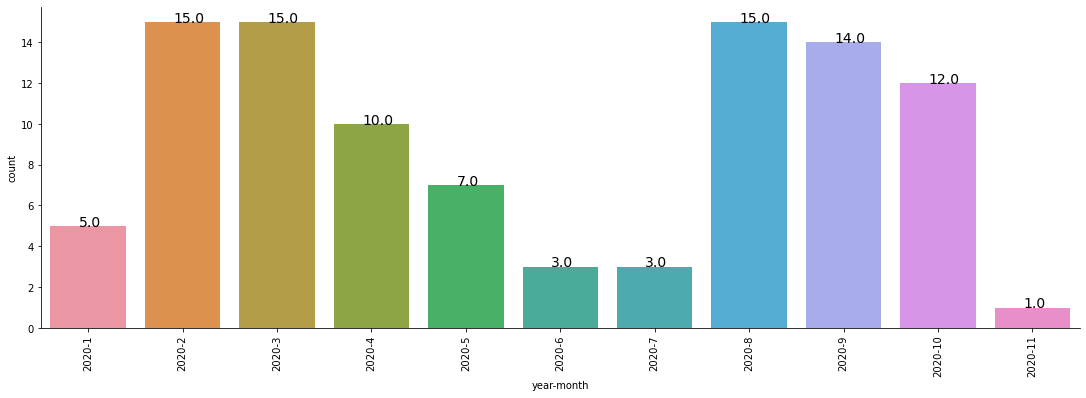

In [43]:
pipline = [{'$group':
               {'_id':
                  { 'Year': {'$year': '$datetime'},
                    'Month': {'$month': '$datetime'} },
                    'count': {'$sum': 1} }  },
            {'$sort': {'_id.Year': 1, '_id.Month': 1}   }]

mongo_cursor = coll_posts.aggregate(pipline)

datapoint = list(mongo_cursor)
df = json_normalize(datapoint)  

# df = pd.DataFrame(list(mongo_cursor))
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)

bar_categories(df, {'x':'year-month', 'y': 'count', 'kind': 'bar',})

### Вывод:
* ...

## 4.2. Распределение постов по времени в течение дня - обзор датасета

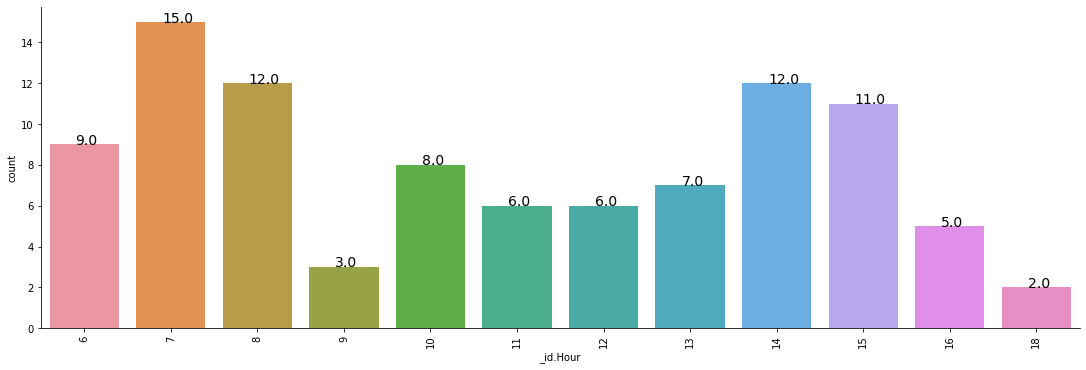

In [44]:
pipline = [{'$group': 
                {'_id': 
                  {'Hour': {'$hour': '$datetime'}},
                  'count': {'$sum': 1}  }  },
            {'$sort': {'_id.Hour': 1}}  ]

mongo_cursor = coll_posts.aggregate(pipline)
df = json_normalize(mongo_cursor)

bar_categories(df, {'x':'_id.Hour', 'y': 'count', 'kind': 'bar',})

### Вывод:
* ...

## 4.3. Среднемесячное количество лайков - обзор датасета

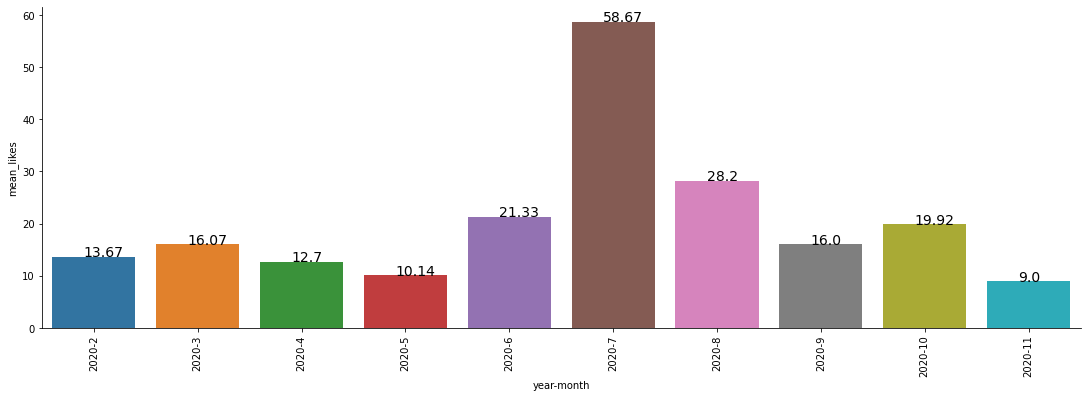

In [45]:
pipline = [{'$group': 
                {"_id":
                  {"Year" : {'$year': "$datetime"},
                   "Month": {'$month': "$datetime"} },
                   "mean_likes" : {'$avg': "$likes"} }  },
            {'$sort': {"_id.Year": 1, "_id.Month": 1}} ]

mc = coll_posts.aggregate(pipline)
df = json_normalize(mc)
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)
bar_categories(df, {'x':'year-month', 'y': 'mean_likes', 'kind': 'bar',})

### Вывод:
* ...

## 4.4. Среднемесячное количество просомотров постов за месяц - обзор датасета

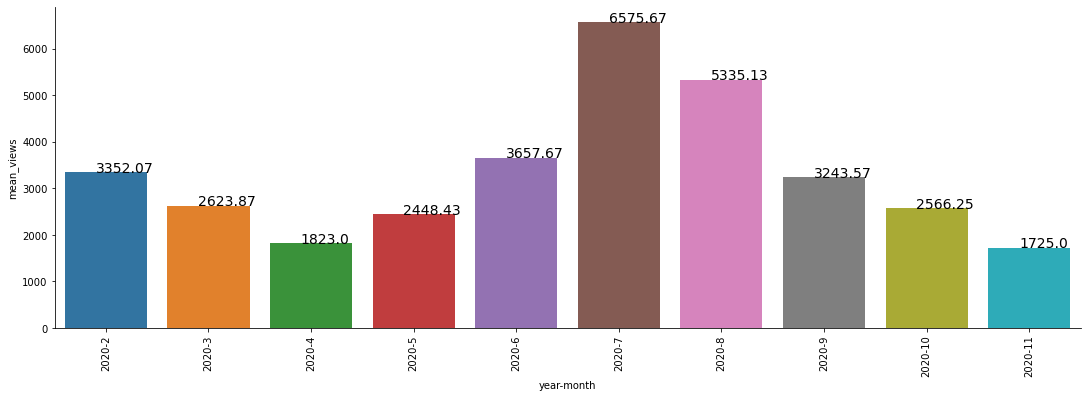

In [46]:
pipline = [{'$group':
               {"_id":
                  {"Year" : {'$year': "$datetime"},
                   "Month": {'$month': "$datetime"} },
                   "mean_views" : {'$avg': "$views"} }  },
            {'$sort': {"_id.Year": 1, "_id.Month": 1}} ]

mc = coll_posts.aggregate(pipline)
df = json_normalize(mc)
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)
bar_categories(df, {'x':'year-month', 'y': 'mean_views', 'kind': 'bar',})

### Вывод:
* ...

## 4.5. Среднемесячное количество просомотров постов в расчёте на количество постов в месяц - обзор датасета

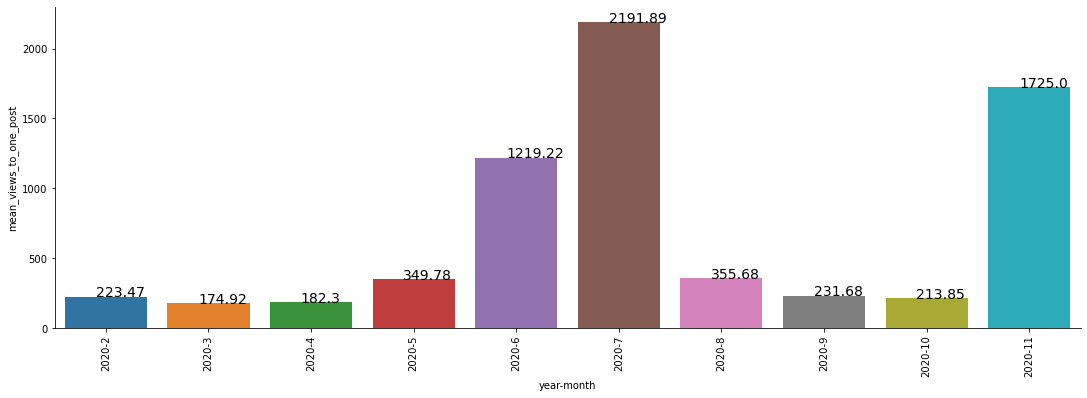

In [47]:
# TODO - просмотры на один пост (среднее + деление)
pipline = [{'$group':
               {"_id":
                  {"Year" : {'$year': "$datetime"},
                   "Month": {'$month': "$datetime"} },
                   "count_posts": {'$sum': 1},
                   "mean_views" : {'$avg': "$views"} }  },
            {'$project': {"name": 1, "mean_views_to_one_post": {'$divide':["$mean_views", "$count_posts"]}}},
            {'$sort': {"_id.Year": 1, "_id.Month": 1}} ]

mc = coll_posts.aggregate(pipline)
df = json_normalize(mc)
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)
bar_categories(df, {'x':'year-month', 'y': 'mean_views_to_one_post', 'kind': 'bar',})

### Вывод:
* ...

## Средняя длина поста в символах - обзор датасета

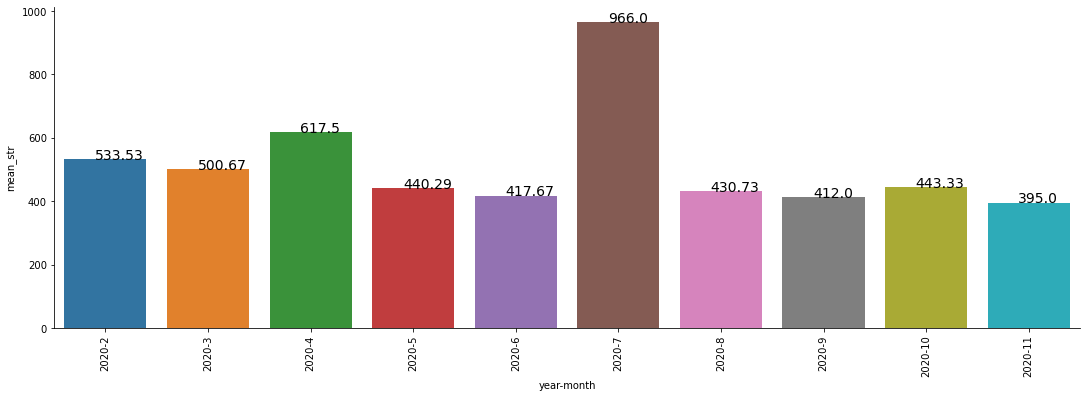

In [48]:
pipline = [{'$group': {"_id": {"Year" : {'$year': "$datetime"},
                               "Month": {'$month': "$datetime"} },
                             "mean_str" : {'$avg': {'$strLenCP': "$text"}} }  },
             {'$sort': {"_id.Year": 1, "_id.Month": 1}} ]

mc = coll_posts.aggregate(pipline)
df = json_normalize(mc)
df['year-month'] = df['_id.Year'].astype(str) +'-'+ df['_id.Month'].astype(str)
bar_categories(df, {'x':'year-month', 'y': 'mean_str', 'kind': 'bar',})

### Вывод:
* ...

## 4.8. Распределение комментаторов по странам и городам - обзор датасета
* 

### 4.8.1. Распределение комментаторов по странам

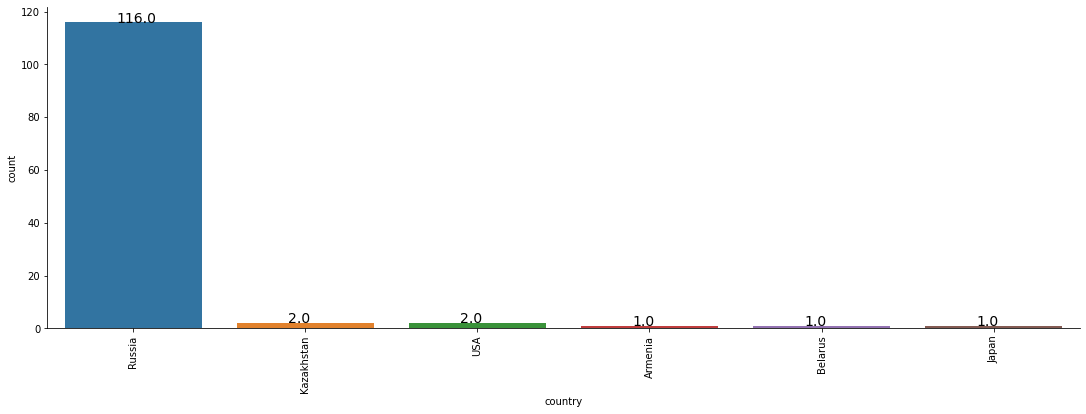

In [49]:
pipline = [{"$match": {"country.title": {'$ne': None}}},
           {'$group': 
               {"_id": "$country.title",
                        "count": {'$sum': 1} } },
            {'$project': 
                {"country":"$_id", "count": 1, "_id":0}},
            {'$sort': {'count': -1}}  ]

mc = coll_profiles.aggregate(pipline)

df = pd.DataFrame(list(mc)).sort_values('count', ascending=False)[0:11]
bar_categories(df, {'x':'country', 'y': 'count', 'kind': 'bar',})

### Вывод:
* ...

### 4.8.2. Распределение комментаторов по городам

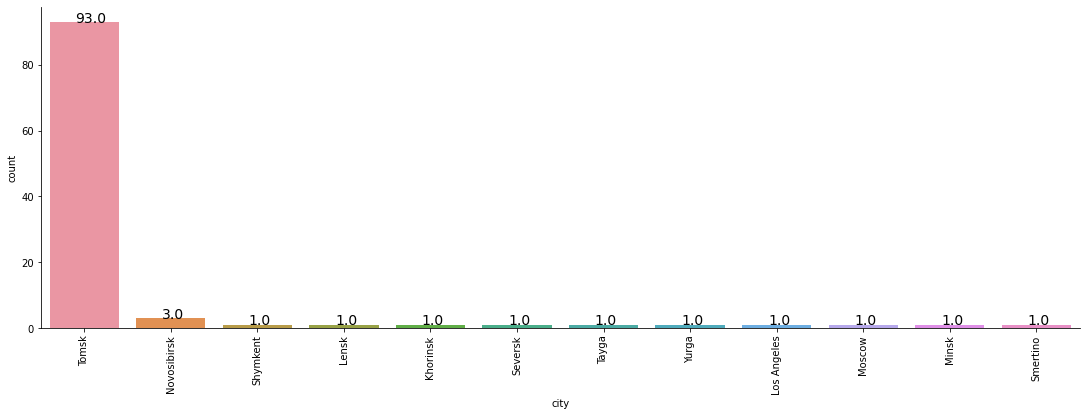

In [50]:
pipline = [{"$match": {"city.title": {'$ne': None}}},
           {'$group': 
               {"_id": "$city.title",
                        "count": {'$sum': 1} } },
            {'$project': 
                {"city":"$_id", "count": 1, "_id":0}},
            {'$sort': {'count': -1}} ]

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('count', ascending=False)[0:12]
bar_categories(df, {'x':'city', 'y': 'count', 'kind': 'bar',})

### Вывод:
* ...

## 4.9. Распределение комментаторов по возрасту - обзор датасета

### Распределение комментаторов по возрасту - полное

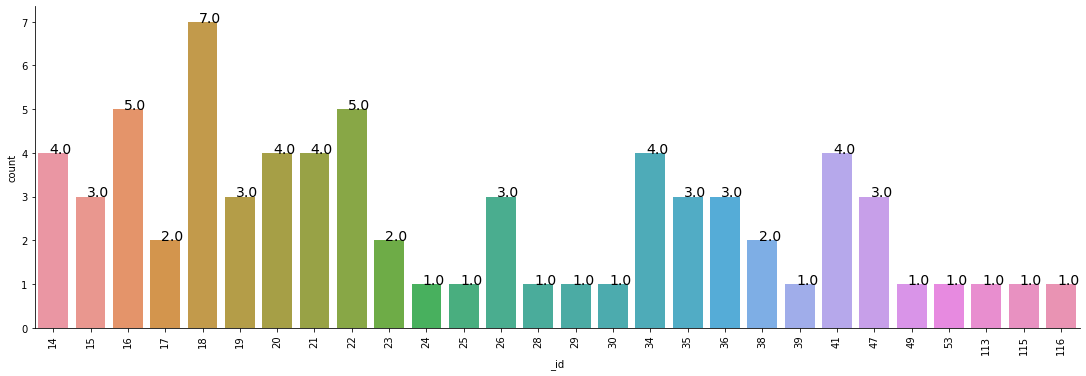

In [51]:
pipline = ([ {'$match': {"bdate": {'$exists': True}}},
             {'$project': {"bdate": 1, "bdate_len": {'$strLenCP': "$bdate"}} },
             {'$match': {"bdate_len": {'$gte': 8}}},
             {'$project': {"bdate": 1, "year": {'$split': ["$bdate", "."]}} },
             {'$unwind': "$year"},
             {'$addFields': {"int_year": {'$toInt': '$year'} }},
             {'$match': {"int_year": {'$gt': 1800}}},
             {'$addFields': {"age": {'$subtract': [2020, '$int_year']} }},
             {'$group': {"_id": "$age", "count": {'$sum': 1}}},
             {'$sort': {'count': -1}}
          ])

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('_id', ascending=True)
df1545 = df.copy()[:31]
df45 = df.copy()[30:]
bar_categories(df, {'x':'_id', 'y': 'count', 'kind': 'bar',})

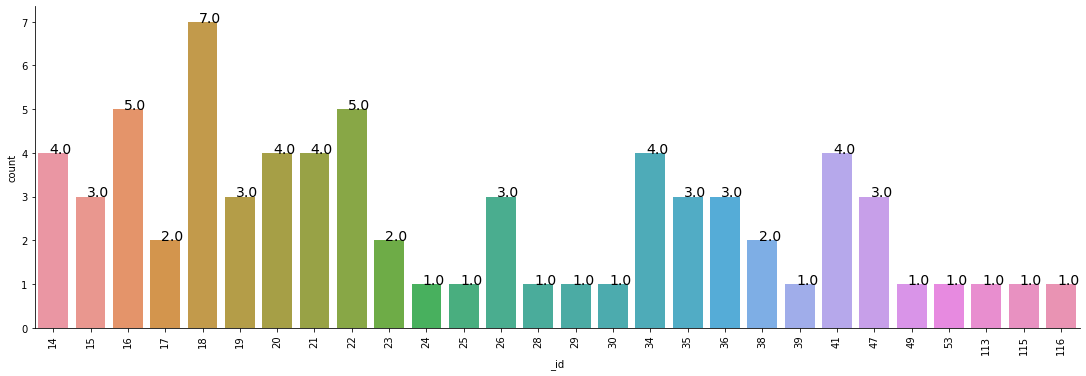

In [52]:
# Обязательно делать проверку на существование поля, иначе не корректно отрабатывает запрос
# Нужна конвертация строки (год) в Int

pipline = ([ {'$match': {"bdate": {'$exists': True}}},
             {'$project': {"bdate": 1, "bdate_len": {'$strLenCP': "$bdate"}} },
             {'$match': {"bdate_len": {'$gte': 8}}},
             {'$project': {"bdate": 1, "year": {'$split': ["$bdate", "."]}} },
             {'$unwind': "$year"},
             {'$addFields': {"int_year": {'$toInt': '$year'} }},
             {'$match': {"int_year": {'$gt': 1800}}},
             {'$addFields': {"age": {'$subtract': [2020, '$int_year']} }},
             {'$group': {"_id": "$age", "count": {'$sum': 1}}},
             {'$sort': {'count': -1}}
          ])

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('_id', ascending=True)
df1545 = df.copy()[:31]
df45 = df.copy()[30:]
bar_categories(df, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### 4.9.2. Распределение комментаторов по возрасту - 15-45

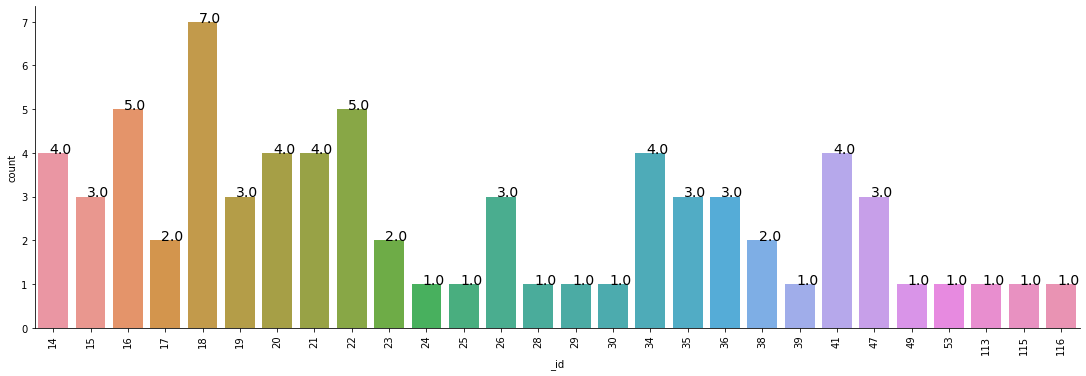

In [53]:
bar_categories(df1545, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### Вывод:
* ...

### 4.9.3. Распределение комментаторов по возрасту - 45 - ...

In [54]:
bar_categories(df45, {'x':'_id', 'y': 'count', 'kind': 'bar',})

ValueError: min() arg is an empty sequence

### Вывод:
* В комментатороах есть всякие шутники с возрастом 118 лет 😂

## Расспределение комментариев по времени

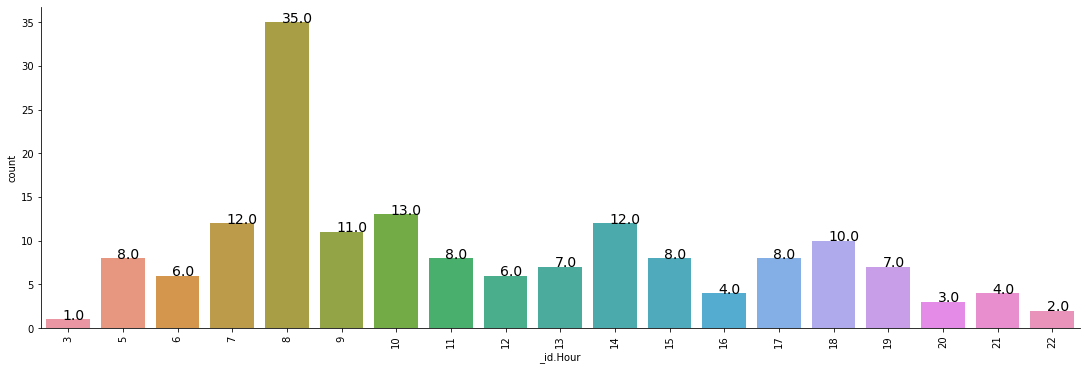

In [55]:
pipline = [{'$group':
                 {'_id': 
                    {'Hour': {'$hour': '$datetime'}},
                     'count': {'$sum': 1}} },
            {'$sort': {'_id.Hour': 1}} ]

mc = coll_comments.aggregate(pipline)
df = json_normalize(mc)

bar_categories(df, {'x':'_id.Hour', 'y': 'count', 'kind': 'bar',})

### Вывод:
* ...

## 4.11. Расспределение комментаторов (работа\учёба) - в текущее время

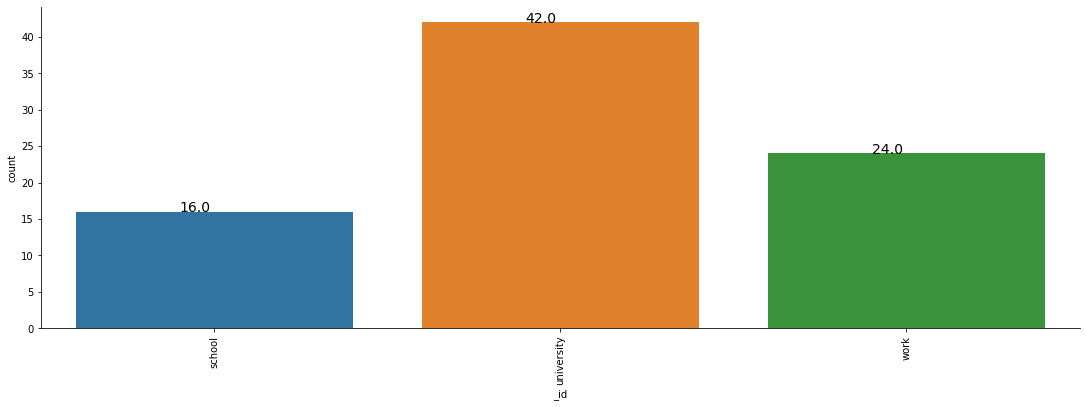

In [56]:
pipline = [{'$match': {'occupation': {'$exists': True}}},
           {'$group': 
               {'_id': '$occupation.type',
                'count': {'$sum': 1}}}
           ]


mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('_id', ascending=True)
bar_categories(df, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### Вывод:
* ...

## 4.12. Отношение к алкоголю и курению
1. резко негативное;
2. негативное;
3. компромиссное;
4. нейтральное;
5. положительное.

### Отношение к курению

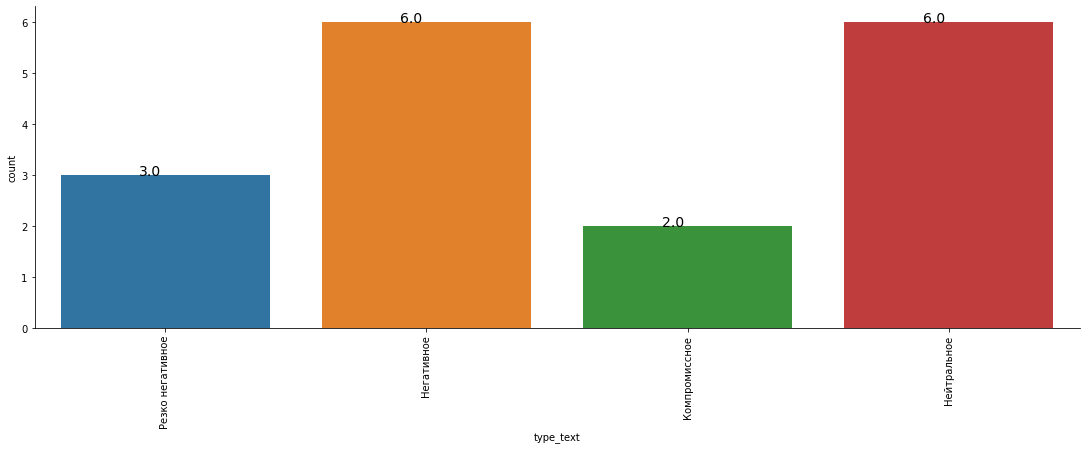

In [57]:
pipline = [{'$match': {'personal.smoking': {'$exists': True, '$ne':0}}},
           {'$group': {'_id': '$personal.smoking',
                       'count': {'$sum': 1}}},
            {'$project': {'type': '$_id', 'count': 1}},
            {"$addFields":
             {'type_text':
               {'$switch':
                 {'branches':
                  [ {'case': {'$eq': ['$type', 1]}, 'then': 'Резко негативное'},
                    {'case': {'$eq': ['$type', 2]}, 'then': 'Негативное'},
                    {'case': {'$eq': ['$type', 3]}, 'then': 'Компромиссное'},
                    {'case': {'$eq': ['$type', 4]}, 'then': 'Нейтральное'},
                    {'case': {'$eq': ['$type', 5]}, 'then': 'Положительное'}
                     ],
                    'default': 'ОШИБКА'
                  }}}},
            {'$sort': {'_id': 1}}]

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('_id', ascending=True)
bar_categories(df, {'x':'type_text', 'y': 'count', 'kind': 'bar',})

### Вывод:
* ...

### 4.12.2 Отношение к алкоголю

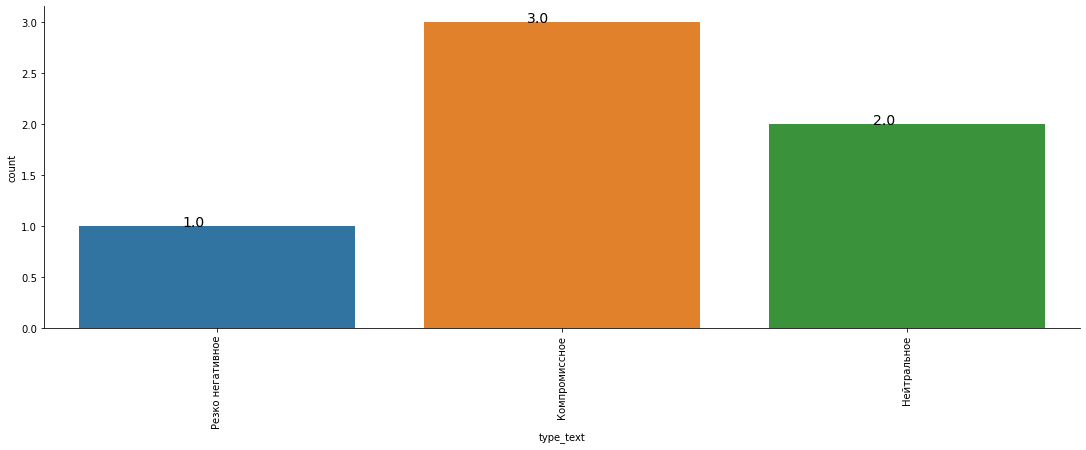

In [58]:
pipline = [{'$match': {'personal.alcohol': {'$exists': True, '$ne':0}}},
           {'$group': {'_id': '$personal.alcohol',
                       'count': {'$sum': 1}}},
            {'$project': {'type': '$_id', 'count': 1}},
            {"$addFields":
             {'type_text':
               {'$switch':
                 {'branches':
                  [ {'case': {'$eq': ['$type', 1]}, 'then': 'Резко негативное'},
                    {'case': {'$eq': ['$type', 2]}, 'then': 'Негативное'},
                    {'case': {'$eq': ['$type', 3]}, 'then': 'Компромиссное'},
                    {'case': {'$eq': ['$type', 4]}, 'then': 'Нейтральное'},
                    {'case': {'$eq': ['$type', 5]}, 'then': 'Положительное'}
                     ],
                    'default': 'ОШИБКА'
                  }}}},
            {'$sort': {'_id': 1}}]

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('_id', ascending=True)
bar_categories(df, {'x':'type_text', 'y': 'count', 'kind': 'bar',})

### Вывод:
* ...

## 4.13. Религиозные воззрения комментаторов

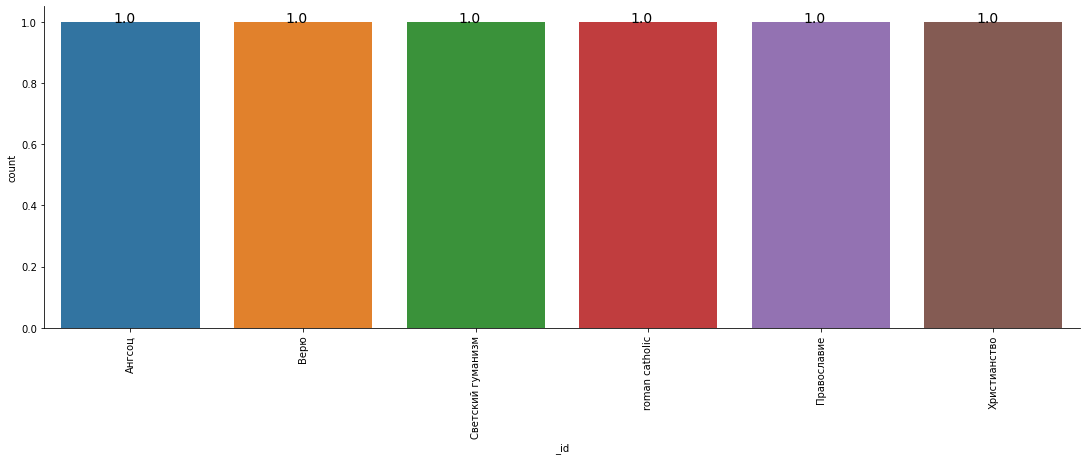

In [59]:
pipline =[{'$match': {'personal.religion': {'$exists': True, '$ne':0}}},
          {'$group': {'_id': '$personal.religion',
                      'count': {'$sum': 1}}},
          {'$sort': {'count':1}}
]

mc = coll_profiles.aggregate(pipline)
df = pd.DataFrame(list(mc)).sort_values('count', ascending=False)
df10 = df.copy()[:13]
df20 = df.copy()[14:]
bar_categories(df10, {'x':'_id', 'y': 'count', 'kind': 'bar',})

### Вывод:
*...